## A Brief Introduction to Data Visualization

### Arielle Frommer

Hello! This notebook will provide a step-by-step guide into data visualization in machine learning. Data visualization can be incredibly useful -- it helps us understand the features of our dataset better, conveys more complex relationships in the data, and reveals trends, clusters, and anaomlies that otherwise may go unnoticed. 

In addition, we often will reduce our data into two or three dimensions before visualizing it (because we ourselves are three-dimensional creatures) -- the machine learning techniques we use for this dimensionality reduction often aim to extract the most important features of our data, thereby providing us with a more streamlined dataset that we can then feed into classification or regression networks or whatever your heart desires!

This notebook will feature Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (tSNE), and Autoencoders as its primary techniques for dimensionality reduction and visualization. But first, let's import some libraries that will come in handy:


In [212]:
# importing numpy for general stuff
import numpy as np

# importing tarfile to grab our data file
import tarfile

# importing pandas to work with DataFrames
import pandas as pd

# importing torch for data organization with Autoencoders
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# importing plotly and mpl_toolkits for graphing data
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D

# importing astropy to access our data file
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.table import Table

# importing scikit learn for miscellaneous machine learning stuff, including PCA and tSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


## Accessing Astronomical Data

For our data, we will be using 3D-HST catalog from the MAST archive. This dataset is described in [Skelton et. al 2014](https://dx.doi.org/10.1088/0067-0049/214/2/24). The dataset features several features of a few thousand galaxies, plus their photometric redshifts. In this tutorial, we will be using the redshifts as our labels, and the rest of the data as our features. In a classification or regression problem, predicting the redshift of a galaxy based on different features would be incredibly useful. In addition, we may want to observe the inherent galaxy classes that emerge from these many features, which may become apparent through visualization. The visualization and dimensionality reduction tasks demonstrated in this notebook would help us prepare the data to do so!

This [tutorial](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Regressing_3D-HST_galaxy_redshift_with_decision_trees/Regressing_3D-HST_galaxy_redshift_with_decision_trees.html)
 also features this dataset, so we will follow their guidelines for data cleaning. This includes removing several features which represent categorical flags or are derived directly from the redshift (which would spoil the nature of our problem!) and encoding the field variable as values. Our data has 28 features and thus 28 dimensions (WOW) so we will aim to reduce it to three-dimensional space so that we can visualize the data!

In [211]:
# accessing astronomical data and putting it into a pandas DataFrame
file_url = 'https://archive.stsci.edu/missions/hlsp/3d-hst/RELEASE_V4.0/Photometry/3dhst_master.phot.v4.1.tar'
tarfile.open(download_file(file_url, cache=True), "r:").extract('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', '.')
data = Table.read('3dhst_master.phot.v4.1/3dhst_master.phot.v4.1.cat', format='ascii').to_pandas()


In [105]:
# encoding the field variable 
label_encoder = LabelEncoder()
data['field'] = label_encoder.fit_transform(data['field'])

# filtering out invalid redshift values
filtered_data = data[(data['z_spec'] > -1)]


In [125]:
# creating our features, excluding the target redshift, values computed with redshift, and other values
columns_to_drop = ['id', 'z_spec', 'Av', 'lmass', 'z_peak', 'flags', 'f140w_flag', 'star_flag', 'use_phot', 'near_star']

# DataFrame with every column except the specified columns
features = filtered_data.drop(columns=columns_to_drop)

# creating our target dataset, which includes only the photometric redshift
targets = filtered_data[['z_spec']]

# converting our targets to a list, which we will use later on in our plots!
target_list = targets['z_spec'].tolist()


## Principal Component Analysis

Principal Component Analysis aims to reduce the dimensionality of the data while aiming to maintain as much variance as possible. But how does it work? First, we calculatie a covariance matrix between all the features of the data. Then, we can determine which components of the data explain the most variance based on their eigenvalues -- our principal components! Finally, we project the data onto the axes of those principal components. By retaining only a subset of these principal components that explain the majority of the variance in the data, PCA effectively reduces the dimensionality of the dataset while preserving its essential structure.

We can utilize sci kit learn's tools to perform PCA fitting on our dataset! Try it out in the cells below:


In [199]:
# doing PCA fitting for 3 components
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

# organizing the results into three arrays of features that I can plot
X = [features[0] for features in reduced_features]
Y = [features[1] for features in reduced_features]
Z = [features[2] for features in reduced_features]


In [217]:
# creating a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=X, y=Y, z=Z, mode='markers', marker=dict(size=5, 
        color=target_list, colorscale='Viridis', opacity=0.8, coloraxis='coloraxis'))])

# setting axis labels
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Feature 3'))

fig.update_layout(title_text='PCA', title_x=0.5, title_y=0.85, title_font=dict(size=20))
    
# adjusting the size of the figure
fig.update_layout(width=600, height=600)

# adding a colorbar
colorbar_title = 'Photometric Z'
fig.update_layout(coloraxis=dict(colorbar=dict(title=colorbar_title), colorscale='viridis'))

# setting axis limits
fig.update_layout(scene=dict(
        xaxis=dict(range=[min(X), max(X)]),
        yaxis=dict(range=[min(Y), max(Y)]),
        zaxis=dict(range=[min(Z), max(Z)]),))

fig.show()


## Principal Component Analysis (Normalized)

We can definitely pick out trends in our data from this scatterplot! However, it looks like an outlier is throwing off our x-axis. To mitigate the risk of outliers messing with our data, we can normalize it -- scaling our data to have a mean of 0 and a standard deviation of 1 using StandardScaler. Check out how PCA looks in the following cells once we've normalized the data! You'll see that our axes look quite a bit more normalized.

In [213]:
# let's normalize! scaling data to have mean of 0 and standard deviation of 1
std_scaler = StandardScaler()
normalized_features = std_scaler.fit_transform(features)


In [214]:
# doing PCA fitting for 3 components
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(normalized_features)

# organizing the results into three arrays of features that I can plot
X_normalized = [features[0] for features in reduced_features]
Y_normalized = [features[1] for features in reduced_features]
Z_normalized = [features[2] for features in reduced_features]


In [218]:
# creating a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=X_normalized, y=Y_normalized, z=Z_normalized, mode='markers', marker=dict(size=5, 
        color=target_list, colorscale='Viridis', opacity=0.8, coloraxis='coloraxis'))])

# setting axis labels
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Feature 3'))

fig.update_layout(title_text='PCA with Normalized Features', title_x=0.5, title_y=0.85, title_font=dict(size=20))
    
# adjusting the size of the figure
fig.update_layout(width=600, height=600)

# adding a colorbar
colorbar_title = 'Photometric Z'
fig.update_layout(coloraxis=dict(colorbar=dict(title=colorbar_title), colorscale='viridis'))

# setting axis limits
fig.update_layout(scene=dict(
        xaxis=dict(range=[min(X), max(X)]),
        yaxis=dict(range=[min(Y), max(Y)]),
        zaxis=dict(range=[min(Z), max(Z)]),))

fig.show()


## t-Distributed Stochastic Neighbor Embedding

Next, let's try another technique: t-Distributed Stochastic Neighbor Embedding, or t-SNE! t-SNE looks at a datapoint's proximity to its neighbors in order to reduce it to a lower dimensionality. First, it compares the probabilities that any two data points are neighbors in observed space and in a low-dimensional latent space that it reduces the data into. Then, it minimizes the divergence between these two probability distributions by using gradient descent to optimize for the best fit. 

In our t-SNE fit, we set learning rate to 'auto' (which will initialize the learning rate based on the data) and the initial values that will reduce our data to be randomized. The perplexity hyperparameter in t-SNE is related to the number of nearest neighbors -- a higher perplexity will retain more global information (looking at more neighbors) in the dimensionality reduction fit than a low perplexity!

Practice testing perplexities of 5, 50, and 150 in the cells below! You'll notice that clusters becomes more pronounced as perplexity increases -- the first graph has hardly any clustering, while the second graph has some small-scale structures, and the third has highly pronounced clusters. This result aligns with our understanding of perplexity -- since this is a large dataset, a higher perplexity value with allow the dimensionality reduction to retain more global structure and result in larger clusters. This perplexity hyperparameter can and should be adjusted based on the size of your dataset and your end goal!


In [123]:
# tSNE visualization with perplexity of 5
reduced_5 = TSNE(n_components=3, perplexity=5, learning_rate='auto', init='random').fit_transform(normalized_features)

# organizing the results into three arrays of features that I can plot
X_5 = [features[0] for features in reduced_5]
Y_5 = [features[1] for features in reduced_5]
Z_5 = [features[2] for features in reduced_5]


In [147]:
# creating a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=X_5, y=Y_5, z=Z_5, mode='markers', marker=dict(size=5, 
        color=target_list, colorscale='Viridis', opacity=0.8, coloraxis='coloraxis'))])

# setting axis labels
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Feature 3'))

fig.update_layout(title_text='tSNE with Perplexity=5', title_x=0.5, title_y=0.85, title_font=dict(size=20))
    
# adjusting the size of the figure
fig.update_layout(width=600, height=600)

# adding a colorbar
colorbar_title = 'Photometric Z'
fig.update_layout(coloraxis=dict(colorbar=dict(title=colorbar_title), colorscale='viridis'))

# setting axis limits
fig.update_layout(scene=dict(
        xaxis=dict(range=[min(X_5), max(X_5)]),
        yaxis=dict(range=[min(Y_5), max(Y_5)]),
        zaxis=dict(range=[min(Z_5), max(Z_5)]),))

fig.show()


In [132]:
# tSNE visualization with perplexity of 50
reduced_50 = TSNE(n_components=3, perplexity=50, learning_rate='auto', init='random').fit_transform(normalized_features)

# organizing the results into three arrays of features that I can plot
X_50 = [features[0] for features in reduced_50]
Y_50 = [features[1] for features in reduced_50]
Z_50 = [features[2] for features in reduced_50]


In [148]:
# creating a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=X_50, y=Y_50, z=Z_50, mode='markers', marker=dict(size=5, 
        color=target_list, colorscale='Viridis', opacity=0.8, coloraxis='coloraxis'))])

# setting axis labels
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Feature 3'))

fig.update_layout(title_text='tSNE with Perplexity=50', title_x=0.5, title_y=0.85, title_font=dict(size=20))
    
# adjusting the size of the figure
fig.update_layout(width=600, height=600)

# adding a colorbar
colorbar_title = 'Photometric Z'
fig.update_layout(coloraxis=dict(colorbar=dict(title=colorbar_title), colorscale='viridis'))

# setting axis limits
fig.update_layout(scene=dict(
        xaxis=dict(range=[min(X_50), max(X_50)]),
        yaxis=dict(range=[min(Y_50), max(Y_50)]),
        zaxis=dict(range=[min(Z_50), max(Z_50)]),))

fig.show()


In [133]:
# tSNE visualization with perplexity of 5
reduced_150 = TSNE(n_components=3, perplexity=150, learning_rate='auto', init='random').fit_transform(normalized_features)

# organizing the results into three arrays of features that I can plot
X_150 = [features[0] for features in reduced_150]
Y_150 = [features[1] for features in reduced_150]
Z_150 = [features[2] for features in reduced_150]


In [149]:
# creating a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=X_150, y=Y_150, z=Z_150, mode='markers', marker=dict(size=5, 
        color=target_list, colorscale='Viridis', opacity=0.8, coloraxis='coloraxis'))])

# setting axis labels
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Feature 3'))

fig.update_layout(title_text='tSNE with Perplexity=150', title_x=0.5, title_y=0.85, title_font=dict(size=20))
    
# adjusting the size of the figure
fig.update_layout(width=600, height=600)

# adding a colorbar
colorbar_title = 'Photometric Z'
fig.update_layout(coloraxis=dict(colorbar=dict(title=colorbar_title), colorscale='viridis'))

# setting axis limits
fig.update_layout(scene=dict(
        xaxis=dict(range=[min(X_150), max(X_150)]),
        yaxis=dict(range=[min(Y_150), max(Y_150)]),
        zaxis=dict(range=[min(Z_150), max(Z_150)]),))

fig.show()


## Autoencoders

Finally, let's try one more dimensionality reduction technique -- and perhaps the most powerful and versatile one at that. Autoencoders are a type of neural network used primarily for unsupervised learning, including dimensionality reduction and feature extraction (which is what we want to do!) 

Autoencoders reduce the dimensionality of a dataset into a smaller latent space using non-linear activation functions and hidden layers, with the aim of reconstructing the data from the latent space and preserving as many of the original features as possible. There are two parts of an autoencoder:
- An *encoder* that reduces and encodes the data into a lower-dimensional latent space
- A *decoder* which undoes the layers of the encoder and reconstructs the original input from this encoded representation

The nonlinear, layered nature of Autoencoders enables them to more effectively capture complex representations of high-dimensional data, which can be valuable for visualization and data reduction! Autoencoders can also be adopted into various other machine learning architectures like convolutional and recurrent neural networks, making them a flexible tool. In the cells below, we initialize an Autoencoder class. Our Autoencoder has two layers, and uses a Leaky ReLu function as its non-linear activation function.

We also must prepare our data to be given to an Autoencoder for training. We use tools from torch and sci kit learn to accomplish this:

In [168]:
# first preparing my data! converting my features and labels to the correct format to be used later
features_torch = torch.from_numpy(normalized_features).to(torch.float32) 
targets_torch = torch.from_numpy(np.array(target_list)).to(torch.long)

# splitting data into training and test datasets
X_train, X_test, class_train, class_test = train_test_split(features_torch, targets_torch, train_size=0.80, shuffle=True)
training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

# setting batch sizes
BATCHSIZE = 128
BATCHSIZE_TEST = 256

# creating Pytorch Datasets
train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)


In [169]:
# setting the sizes of our various layers
INPUT_SIZE = 28 # number of input features
LATENT_SIZE = 3 # number of latent features
HIDDEN_SIZE = 10 # number of featurse to store in the hidden layers


In [170]:
# note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# first, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

# creating our Encoder
class Encoder(nn.Module):
    def __init__(self, seed=42):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # initializing the linear layers
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE)
        self.fc2 = nn.Linear(HIDDEN_SIZE,LATENT_SIZE)

        # initializing weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # defining a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        
        # using the nonlinear Leaky ReLU function
        x = torch.nn.LeakyReLU()(self.fc1(x))
        z = self.fc2(x)
        return z

# creating our decoder
class Decoder(nn.Module):
    def __init__(self, seed=42):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # initializing the first decoder layer to move from the latent size to the hidden size
        self.fc1 = nn.Linear(LATENT_SIZE, HIDDEN_SIZE)
        
        # initializing the second decoder layer to move from the hidden size to the input size
        self.fc2 = nn.Linear(HIDDEN_SIZE,INPUT_SIZE)

        # initalizing the weights and biases following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # using the same activation function (Leaky ReLU) as recommended in order to define forward propagation
    def forward(self, z):
        
        # moving from latent space to hidden space
        x = torch.nn.LeakyReLU()(self.fc1(z))
        
        # moving from hidden space into output (with the same dimensonality as the input)
        x = self.fc2(x)
        return x

# creating the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    # defining the encoder and decoder structures
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x
    

## Training our Autoencoder

Next, we create a training and test loop to train our Autoencoder! The training loop takes in four inputs -- the dataloader, which loads the data batch by batch; the Autoencoder model, which trains the data and finds the best set of model parameters; the loss function, which determines the function that will be used to minimize error; and the optimizer function, which computes the gradient using the loss function and updates the model parameters.

The "test" loop uses a similar structure and keeps track of the test set for each epoch, but it will not update the model weights -- the training loop is used to update the model parameters. In the structure provided, we use the mean-squared error function to calculate our error, and the Adam optimizer — a more advanced form of gradient descent — to compute the gradient and update the model parameters. The learning rate of the optimizer sets how much the optimizer will update the model parameters based on each gradient, and can help the model find a better fit if it is set well. 

Finally, we can plot our overall loss over time. Ideally, our loss should decrease exponentially, as we want to minimize the difference between our reconstructed features and input features. Check out our loss over epoch in the cells below:

In [182]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterating over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # computing prediction of the model
        pred = model(X)
        # computing the loss function
        loss = loss_fn(pred,X)

        # backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            
            print(f"loss: {loss:>7f}  [{current}/{size}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg loss: {test_loss:>8f} \n")

    return test_loss


In [188]:
# creating an instance of the Autoencoder class
AE = Autoencoder()

# setting epochs and learning rate, which can be adjusted accordingly
EPOCHS = 300
LEARNING_RATE = 1e-3

# using MeanSquaredError for the loss function
loss_fn = nn.MSELoss()
# using Adam Optimizer for the optimizer function
optimizer = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)

# initalizing our loss
train_loss = []
test_loss  = []

# training our Autoencoder
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")


Epoch 1
-------------------------------
loss: 0.756173  [0/4286]
 Avg loss: 0.734866 

Epoch 2
-------------------------------
loss: 0.693870  [0/4286]
 Avg loss: 0.682858 

Epoch 3
-------------------------------
loss: 3.768759  [0/4286]
 Avg loss: 0.620998 

Epoch 4
-------------------------------
loss: 3.416264  [0/4286]
 Avg loss: 0.592250 

Epoch 5
-------------------------------
loss: 0.662856  [0/4286]
 Avg loss: 0.576085 

Epoch 6
-------------------------------
loss: 0.504376  [0/4286]
 Avg loss: 0.574365 

Epoch 7
-------------------------------
loss: 0.617858  [0/4286]
 Avg loss: 0.560872 

Epoch 8
-------------------------------
loss: 0.703228  [0/4286]
 Avg loss: 0.549028 

Epoch 9
-------------------------------
loss: 0.552088  [0/4286]
 Avg loss: 0.530955 

Epoch 10
-------------------------------
loss: 0.578535  [0/4286]
 Avg loss: 0.543537 

Epoch 11
-------------------------------
loss: 0.462509  [0/4286]
 Avg loss: 0.565773 

Epoch 12
-------------------------------


 Avg loss: 0.320294 

Epoch 95
-------------------------------
loss: 0.214878  [0/4286]
 Avg loss: 0.298319 

Epoch 96
-------------------------------
loss: 0.857635  [0/4286]
 Avg loss: 0.295680 

Epoch 97
-------------------------------
loss: 0.291044  [0/4286]
 Avg loss: 0.300792 

Epoch 98
-------------------------------
loss: 0.280965  [0/4286]
 Avg loss: 0.337140 

Epoch 99
-------------------------------
loss: 0.336260  [0/4286]
 Avg loss: 0.285103 

Epoch 100
-------------------------------
loss: 0.196367  [0/4286]
 Avg loss: 0.297738 

Epoch 101
-------------------------------
loss: 0.288279  [0/4286]
 Avg loss: 0.282639 

Epoch 102
-------------------------------
loss: 0.359980  [0/4286]
 Avg loss: 0.283309 

Epoch 103
-------------------------------
loss: 0.233527  [0/4286]
 Avg loss: 0.270113 

Epoch 104
-------------------------------
loss: 0.236707  [0/4286]
 Avg loss: 0.273165 

Epoch 105
-------------------------------
loss: 0.240775  [0/4286]
 Avg loss: 0.278021 

Epoc

 Avg loss: 0.214704 

Epoch 191
-------------------------------
loss: 0.164160  [0/4286]
 Avg loss: 0.216508 

Epoch 192
-------------------------------
loss: 0.138236  [0/4286]
 Avg loss: 0.206787 

Epoch 193
-------------------------------
loss: 0.165236  [0/4286]
 Avg loss: 0.224483 

Epoch 194
-------------------------------
loss: 0.178281  [0/4286]
 Avg loss: 0.201351 

Epoch 195
-------------------------------
loss: 0.257130  [0/4286]
 Avg loss: 0.217748 

Epoch 196
-------------------------------
loss: 0.164213  [0/4286]
 Avg loss: 0.204462 

Epoch 197
-------------------------------
loss: 0.209170  [0/4286]
 Avg loss: 0.215731 

Epoch 198
-------------------------------
loss: 0.169072  [0/4286]
 Avg loss: 0.203303 

Epoch 199
-------------------------------
loss: 0.345581  [0/4286]
 Avg loss: 0.223336 

Epoch 200
-------------------------------
loss: 0.183783  [0/4286]
 Avg loss: 0.218107 

Epoch 201
-------------------------------
loss: 0.178560  [0/4286]
 Avg loss: 0.210338 


 Avg loss: 0.199096 

Epoch 284
-------------------------------
loss: 0.152440  [0/4286]
 Avg loss: 0.222502 

Epoch 285
-------------------------------
loss: 0.176446  [0/4286]
 Avg loss: 0.196693 

Epoch 286
-------------------------------
loss: 0.179726  [0/4286]
 Avg loss: 0.200805 

Epoch 287
-------------------------------
loss: 0.156438  [0/4286]
 Avg loss: 0.197177 

Epoch 288
-------------------------------
loss: 0.162580  [0/4286]
 Avg loss: 0.203962 

Epoch 289
-------------------------------
loss: 0.158844  [0/4286]
 Avg loss: 0.209013 

Epoch 290
-------------------------------
loss: 0.171726  [0/4286]
 Avg loss: 0.311386 

Epoch 291
-------------------------------
loss: 0.194590  [0/4286]
 Avg loss: 0.204296 

Epoch 292
-------------------------------
loss: 0.167009  [0/4286]
 Avg loss: 0.233603 

Epoch 293
-------------------------------
loss: 0.276672  [0/4286]
 Avg loss: 0.215901 

Epoch 294
-------------------------------
loss: 0.168631  [0/4286]
 Avg loss: 0.194946 


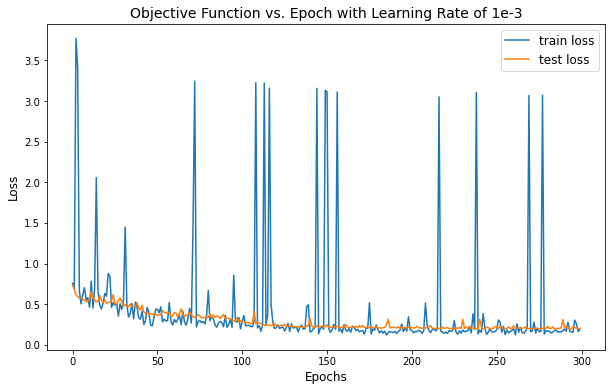

final test loss: 0.20279952883720398


In [219]:
# setting the epochs
x = range(0, 300)

# grabbing train loss
y = train_loss

# grabbing test loss
z = test_loss

# setting plot size
plt.figure(figsize=(10, 6))

# plotting train and test loss
plt.plot(x, y, label='train loss')
plt.plot(x, z, label='test loss')

# displaying axes labels, title, and legend
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Objective Function vs. Epoch with Learning Rate of 1e-3', fontsize=14)
plt.legend(fontsize=12)

plt.show()

print('final test loss:', z[299])


## Visualizing our Latent Space

Finally, we can visualize the three-dimensional latent space that our Autoencoder has created. We can first access this latent space by passing our data through the Encoder class we created, then can grab these latent features and plot them. See our final visualization of the encoded data in the cells below:


In [195]:
# encoding our data
latent_features = AE.encoder(features_torch)

# detaching the data from the Autoencoder
encoded_data = latent_features.detach()

# converting to a numpy array
encoded_features = encoded_data.numpy()


In [209]:
# organizing the results into three arrays of features that I can plot
X_encoded = [features[0] for features in encoded_features]
Y_encoded = [features[1] for features in encoded_features]
Z_encoded = [features[2] for features in encoded_features]


# preparing the color map for redshifts
target_list = targets['z_spec'].tolist()

# creating a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=X_encoded, y=Y_encoded, z=Z_encoded, mode='markers', marker=dict(size=5, 
        color=target_list, colorscale='Viridis', opacity=0.8, coloraxis='coloraxis'))])

# setting axis labels
fig.update_layout(scene=dict(xaxis_title='Feature 1', yaxis_title='Feature 2', zaxis_title='Feature 3'))

fig.update_layout(title_text='Encoded Latent Representation', title_x=0.5, title_y=0.85, title_font=dict(size=20))
    
# adjusting the size of the figure
fig.update_layout(width=600, height=600)

# adding a colorbar
colorbar_title = 'Photometric Z'
fig.update_layout(coloraxis=dict(colorbar=dict(title=colorbar_title), colorscale='viridis'))

# setting axis limits
fig.update_layout(scene=dict(
        xaxis=dict(range=[min(X_encoded), max(X_encoded)]),
        yaxis=dict(range=[min(Y_encoded), max(Y_encoded)]),
        zaxis=dict(range=[min(Z_encoded), max(Z_encoded)]),))

fig.show()


This notebook has been a brief introduction into various dimensionality reduction techniques used for visualization. These techniques enable us to extract important features from astronomical data and visualize, trends, patterns, anomalies, and classes that may be inherent to but highly complex and difficult to observe in the raw data. Try these techniques out yourself and see what you may find!

## The End! :)